In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np

import scienceplots
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png',}

from sklearn import metrics
import pandas as pd
from pprint import pprint

pd.set_option('display.max_rows', 128)
pd.set_option('display.max_columns', 128)

plt.rcdefaults()
#plt.style.use(['science', 'ieee', 'no-latex'])

In [2]:
def monthly_plot(data: pd.DataFrame, key:str, month:int, year:int, ax, vmin:float=None, vmax:float=None):
    data = data[(data.index.year == year) & (data.index.month == month)]

    array = np.full(shape=(32, 24), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.day, ts.hour] = item[key]

    ax.imshow(array.T, cmap='magma', vmin=vmin, vmax=vmax, interpolation='none', aspect='auto')
    #ax.set_xlim(0.5, 31.5)

    ax.grid(False)

    # Invert the vertical axis
    #ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # Remove all spines
    ax.set_frame_on(False)


def weekly_plot(daily_data: pd.DataFrame, key: str, year:int, ax):
    data = daily_data

    assert isinstance(data.index, pd.DatetimeIndex)
    new_index = pd.date_range(start=f'{data.index.year.min()}-01-01', end=f'{data.index.year.max()+1}-01-01', freq='1D', tz=data.index.tz)
    data = data.reindex(new_index)

    data = data[(data.index.year == year)]

    # Lets figure out the size of array
    n_weeks = data.index.isocalendar().week.unique().max() + 1
    n_days = 7

    # Sorry. I couldn't find more efficient way to do it.
    array = np.full(shape=(n_weeks, n_days), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.week, ts.dayofweek] = item[key]

    ax.imshow(array.T, cmap='magma', interpolation='none')

    ax.set_xlim(0.5, n_weeks)

    ax.grid(False)

    weekdays = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
    ax.set_yticks(range(7), weekdays)

    ax.set_xlabel('week number')

    # # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # # Remove all spines
    ax.set_frame_on(False)

In [3]:
df = pd.read_parquet('../../data/refit-dataset-hourly.parquet')
df = df.sort_values(by='timestamp').reset_index(drop=True)

df.rename(columns={'aggregate': 'energy', 'appliances_owned': 'n_appliances'}, inplace=True)

# Fix `construction_year`
def fix_construction_year(value: str) -> int:
    """Possible values:
    array([' 1975-1980    ', ' -      ', ' 1988     ', ' 1850-1899     ',
       ' 1878     ', ' 2005     ', ' 1965-1974    ', ' 1966     ',
       ' 1919-1944    ', ' 1945-1964    ', ' 1991-1995    ',
       ' post 2002    ', ' 1981-1990    ', ' mid 60s     '], dtype=object)
    """
    value = value.strip()
    if '-' in value:
        value = value.split('-')
        value = list(filter(None, value))  # remove empty strings
        if len(value) == 2:
            if value[0].isdigit() and value[1].isdigit():
                start, end = value
                # Two digit struct. Might not be the best, but I will take the first available
                return int(start)
            
        elif len(value) == 1 and value[0].isdigit():
            return int(value[0])
        
        elif len(value) == 0:
            return 1960  # Assumption
        
    if 'post' in value:
        value = value.split(' ')[-1]
        if value.isdigit():
            return int(value)
        
    if 'mid' in value and value.endswith('s'):
        value = value.split(' ')[-1][:-1]
        if value.isdigit():
            return 1900 + int(value)
        
    if value.isdigit():
        return int(value)
        
    raise ValueError(f'You didn\'t handle "{value}"')

df.drop(columns=['appliances'], inplace=True)
df['construction_year'] = df.construction_year.apply(fix_construction_year)

df['house_size'] = df.house_size.apply(lambda size: int(size.strip().split()[0]))
df['house_type'] = df.house_type.apply(lambda x: x.strip().lower())


ts_cols = [
    'energy', 'appliance1', 'appliance2', 'appliance3', 'appliance4', 'appliance5',
    'appliance6', 'appliance7', 'appliance8', 'appliance9',
]


for col in ts_cols:
    # Wh --> kWh
    df[col] /= 1000.0

# for _, group in df.groupby(by=[df.timestamp.dt.date, df.house]):
#     invalid_values = group['energy'] > 0.001

#     if invalid_values.sum() < 4:
#         df.loc[invalid_values.index, 'energy'] = np.nan

# df.head(3).T
#df[(df.timestamp.dt.year == 2013) & (df.timestamp.dt.month == 11)]

print('Samples:')
pprint({x: len(df[(df.house == x) & df.energy.notna()]) for x in df.house.unique()})

Samples:
{1: 15335,
 2: 14819,
 3: 14752,
 4: 15216,
 5: 15561,
 6: 13859,
 7: 14717,
 8: 13322,
 9: 13634,
 10: 14089,
 11: 9413,
 12: 11705,
 13: 11966,
 15: 13618,
 16: 13049,
 17: 11279,
 18: 10590,
 19: 11292,
 20: 11048,
 21: 11756}


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]


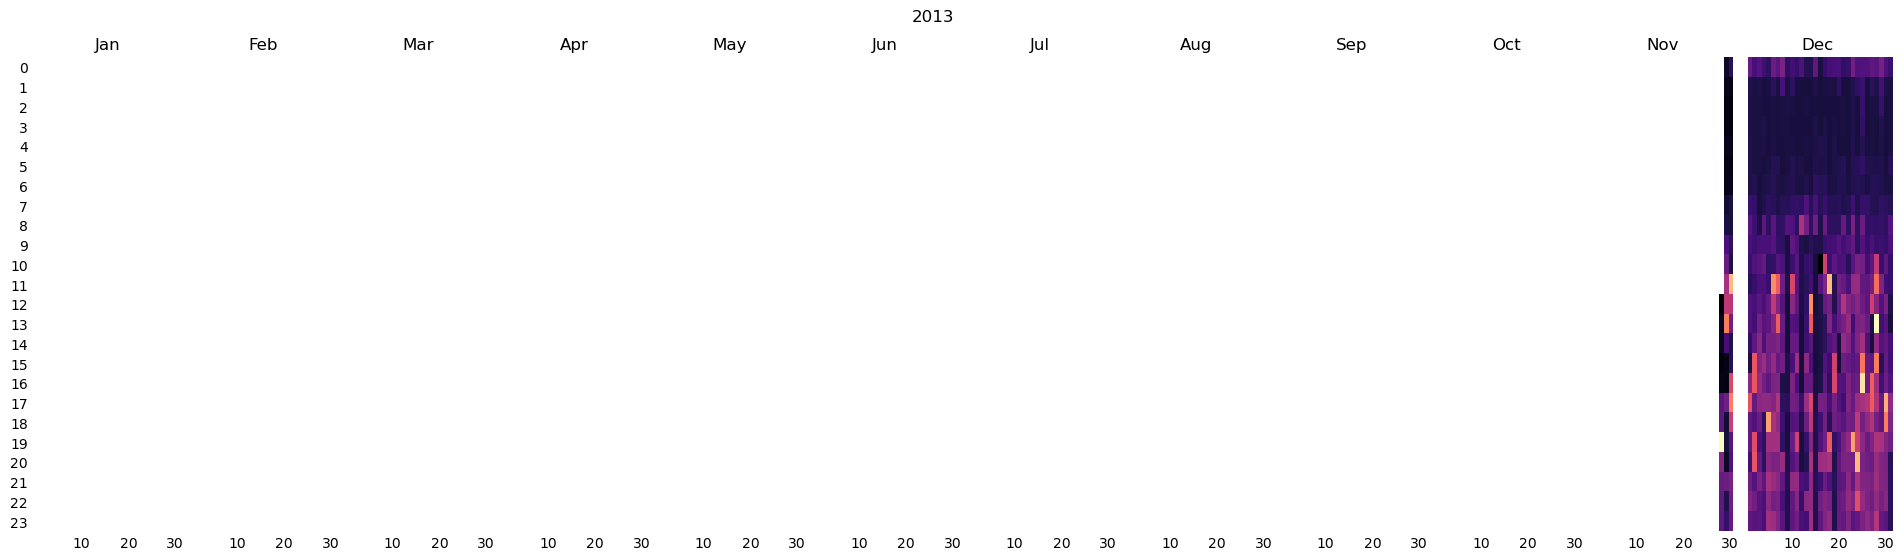

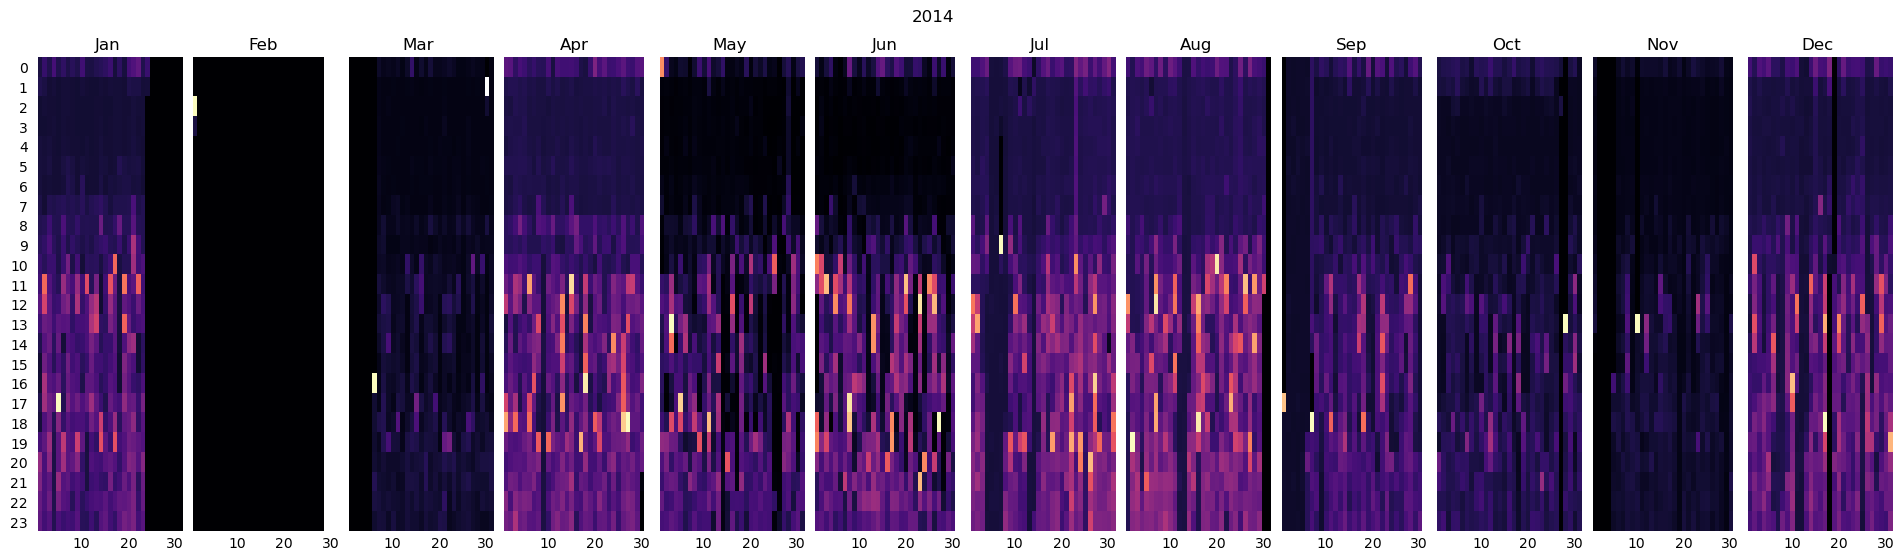

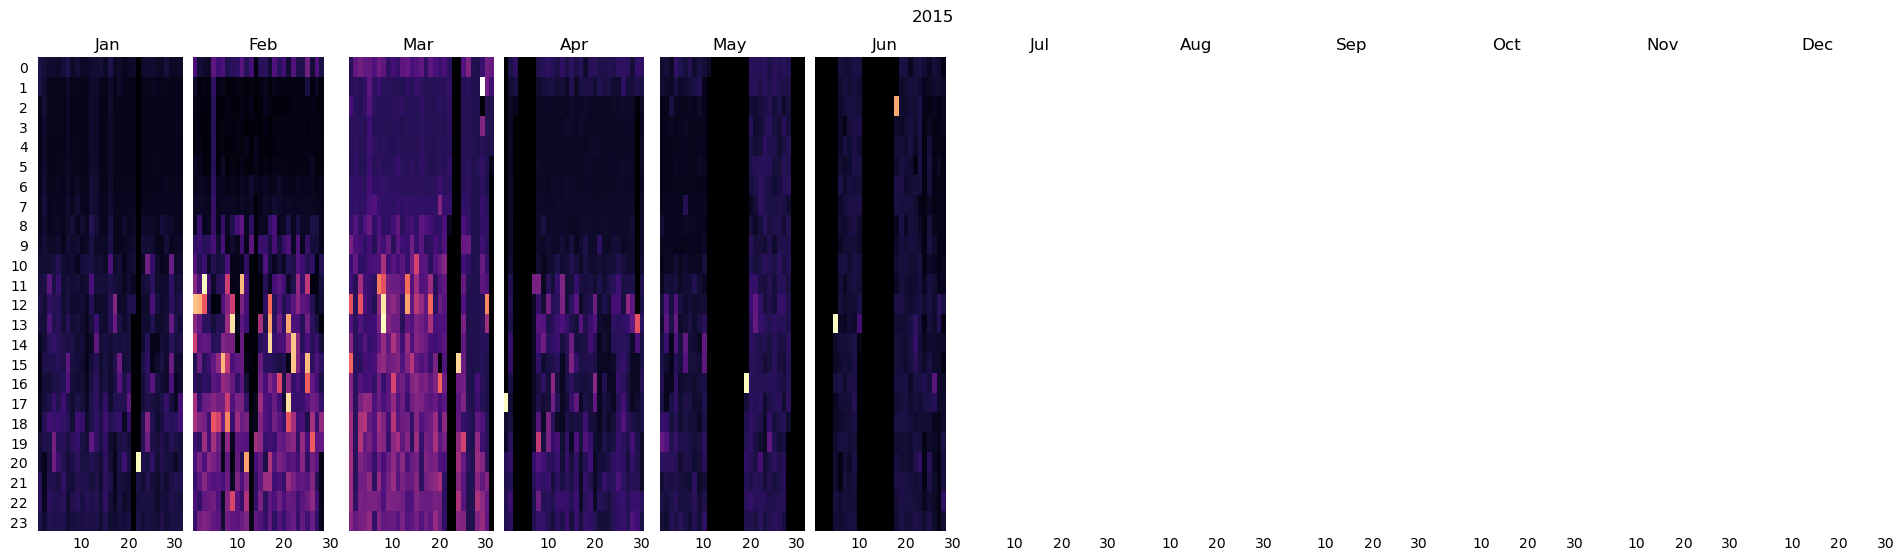

In [4]:
print(sorted(df.house.unique()))

key = 'energy'
view = df[(df.house == 6)]

view = view.set_index('timestamp')
view = view[[key]].resample('1H').sum(min_count=1)

#vmin, vmax = 0, view[key].quantile(0.99)
vmin, vmax = None, None

years = view.index.year.unique()
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(years):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)
    
    fig.suptitle(year)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(view, key, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()


Skip 2013


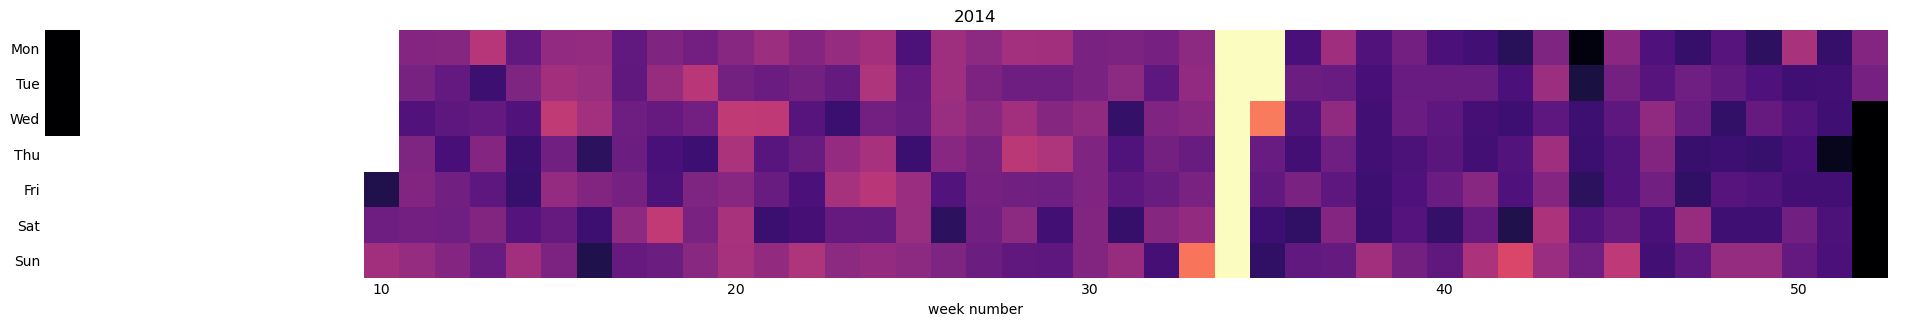

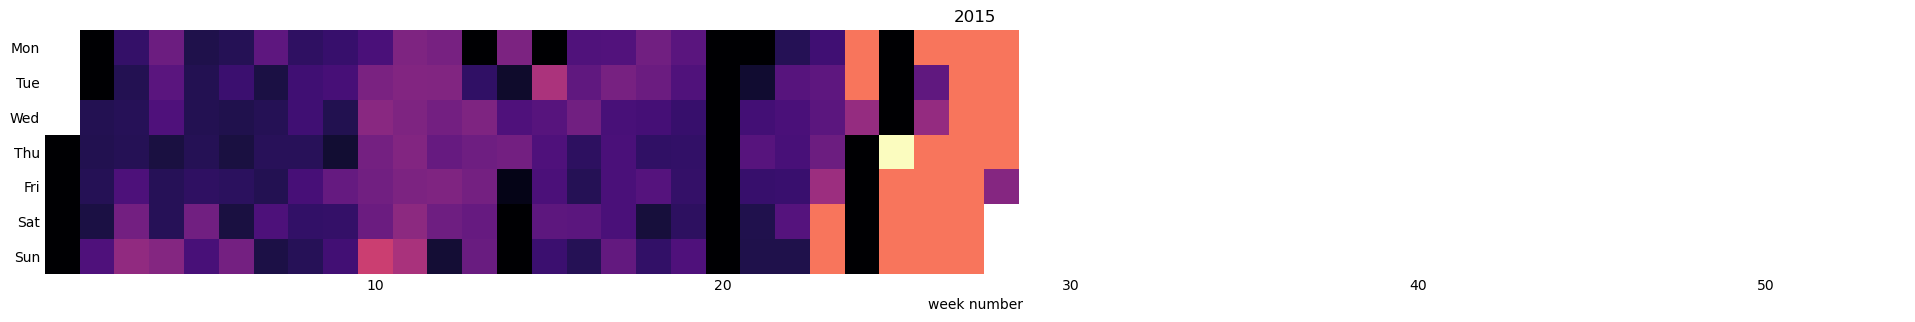

In [5]:
key = 'energy'
years = df.timestamp.dt.year.unique()
view = df[(df.house == 21)]


view = view.set_index('timestamp')
view = view[[key]].resample('1D').sum(min_count=1)

for i, year in enumerate(years):
    if len(view[view.index.year == year]) == 0:
        print(f'Skip {year}')
        continue

    fig, axes = plt.subplots(ncols=1, figsize=(20, 6), sharey=True)
    weekly_plot(view, key, year, axes)

    axes.set_title(year)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

In [6]:
key = 'energy'

if False:
    for _, group in df.groupby(by=[df.timestamp.dt.date, df.house]):

        # If median value repeats more than 5-times, it's probably an error
        if (group[key] == group[key].median()).sum() >= 5:
            sub = df.loc[group.index, [key]]
            sub[sub[key] == sub[key].median()] = np.nan

        # If it's 0 more than 5 times, its an error
        if (df.loc[group.index, key] == 0).sum() > 5:
            df.loc[group.index, key] = np.nan

        # difference between min and max less than 50Wh, its and error
        if (group[key].max() - group[key].min()) <= 50:
            df.loc[group.index, key] = np.nan


    # Highest 0.01 values are probably an error.
    for _, group in df.groupby(by=df.house):
        sub = df.loc[group.index, [key]]
        sub[sub[key] > sub[key].quantile(0.99)] = np.nan

#for _, group in df.groupby(by=[df.timestamp.dt.date, df.house]):
#    valid_values = group['energy'] > 0.001
#
#    if valid_values.sum() < 4:
#        df.loc[valid_values.index, 'energy'] = np.nan


# Assumption: Considering that measurements were collected in 5-7 sec intervals, it's highly unlikely for household to have absolute zero Wh consumption.
# We will consider those datapoints invalid.
df.loc[df.energy == 0, 'energy'] = np.nan

print('Samples:')
pprint({x: len(df[(df.house == x) & df.energy.notna()]) for x in df.house.unique()})

Samples:
{1: 13513,
 2: 11350,
 3: 13004,
 4: 13582,
 5: 14403,
 6: 11829,
 7: 12929,
 8: 12003,
 9: 11581,
 10: 12949,
 11: 8417,
 12: 10985,
 13: 9378,
 15: 12130,
 16: 11150,
 17: 10629,
 18: 9996,
 19: 10626,
 20: 10412,
 21: 10700}


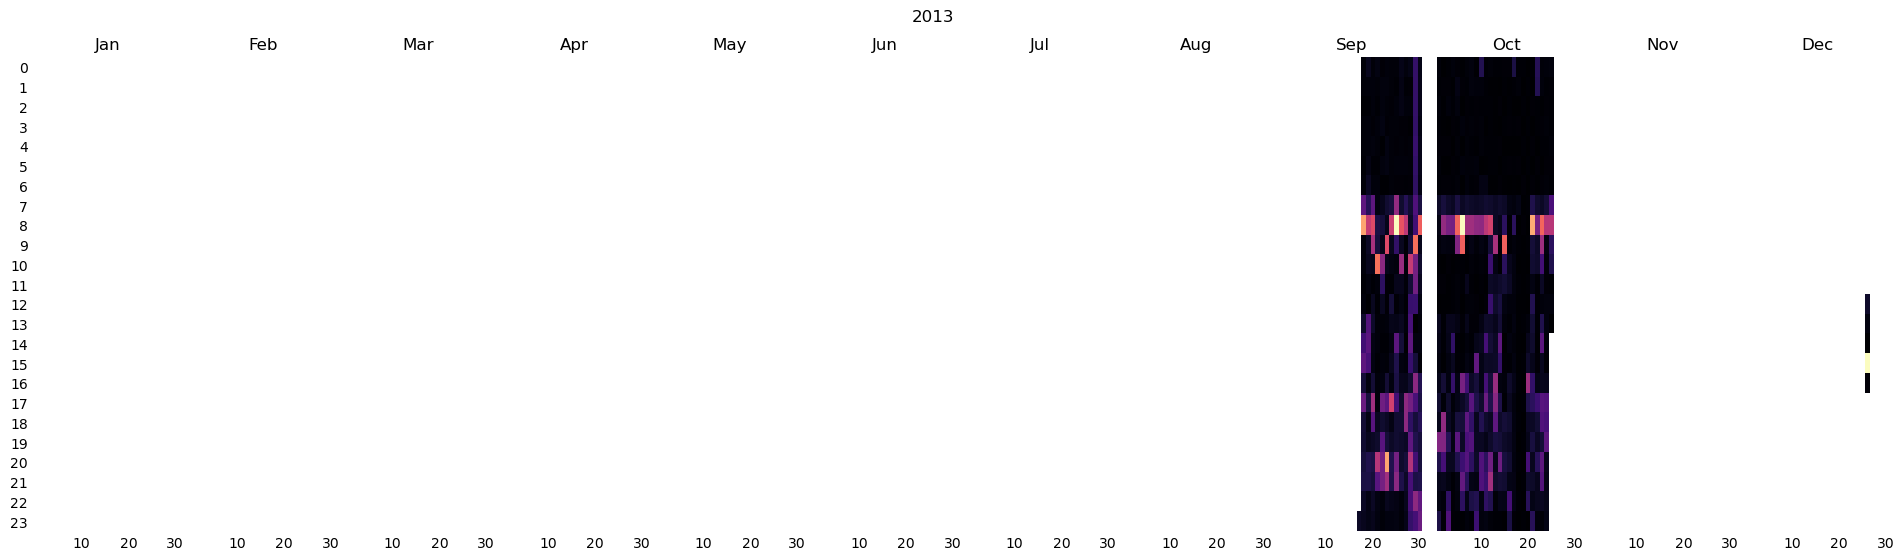

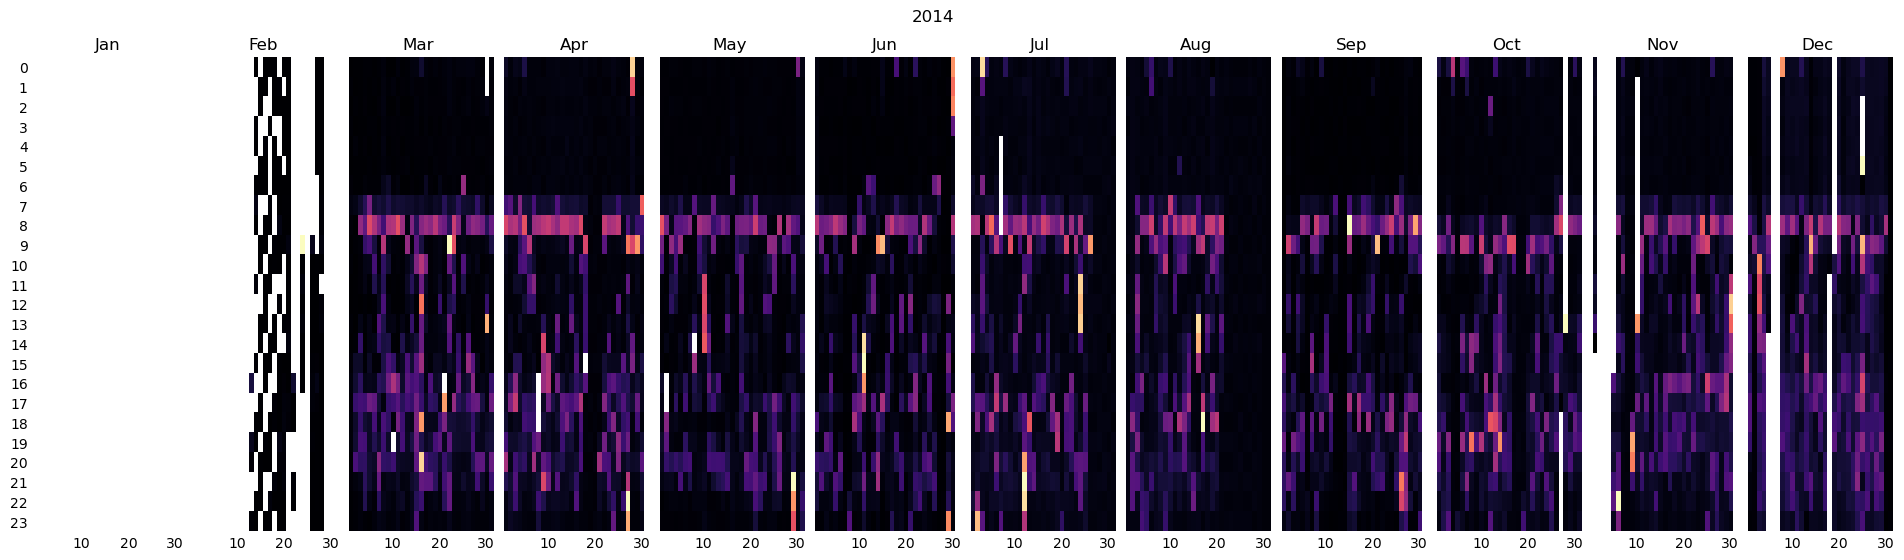

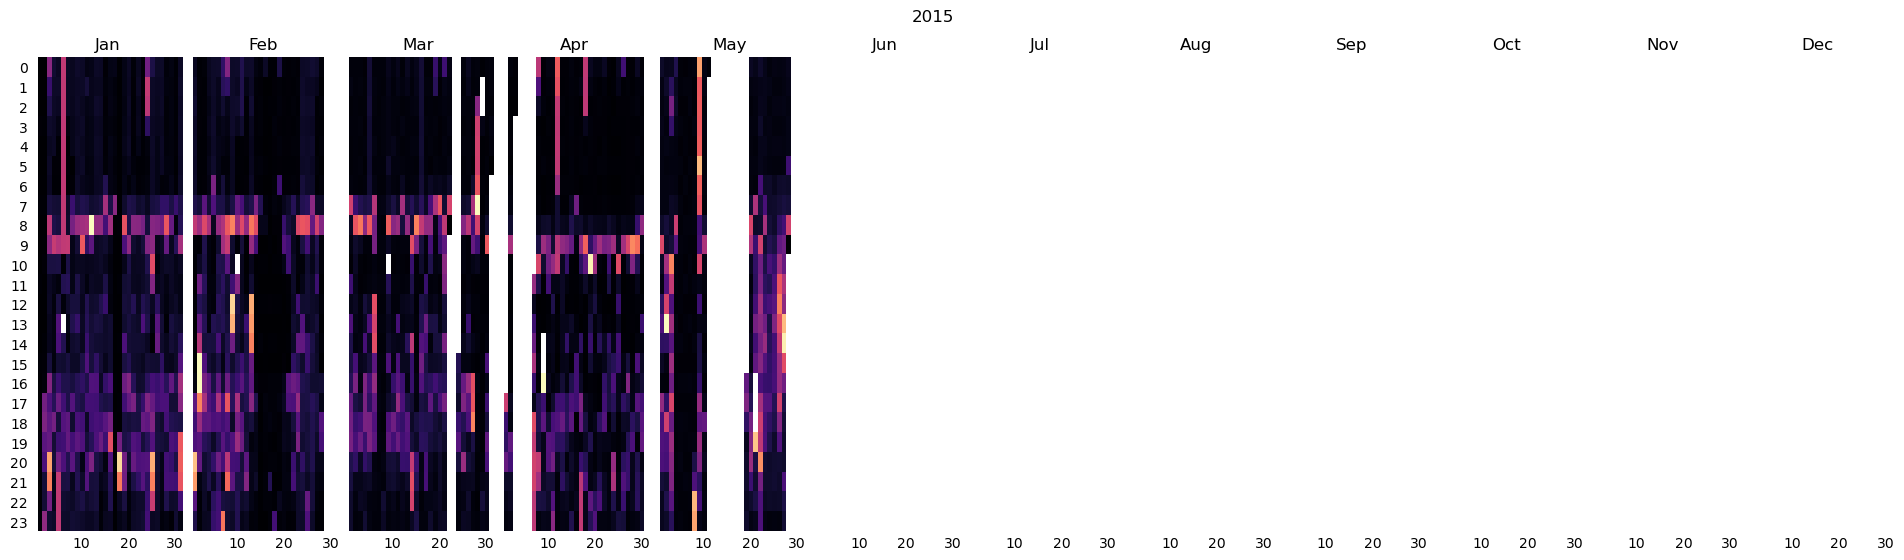

In [7]:
key = 'energy'
view = df[(df.house == 2)].dropna()
view = view.set_index('timestamp')

years = view.index.year.unique()

#vmin, vmax = view[key].quantile(0.01), view[key].quantile(0.99)
vmin, vmax = None, None

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(years):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)

    fig.suptitle(year)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(view, key, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

In [8]:
# We are searching for indices for
# *personal grooming*
# cooking
# cleaning
# entertainment
# work at home

In [9]:
for col in ('personal grooming', 'cooking', 'cleaning', 'entertainment', 'work at home', 'heating', 'PVs', 'bedroom'):
    df[col] = 0.0

appliances = lambda group, appliances: sum(group[f'appliance{a}'] for a in appliances)


for house_idx, group in df.groupby(by=df.house):
    personal = 0
    cooking = 0
    cleaning = 0
    entertainment = 0
    work_at_home = 0
    heating = 0
    bedroom_activity = 0
    pvs = 0


    if house_idx == 1:
        # No relevant sources
        personal = 0
        # No relevant sources
        cooking = 0
        # 4.Tumble Dryer, 5.Washing Machine, 6.Dishwasher
        cleaning = appliances(group, [4, 5, 6])
        # 7.Computer Site, 8.Television Site
        entertainment = appliances(group, [7, 8])
        # 7.Computer Site
        work_at_home = appliances(group, [7])
        # 9.Electric Heater
        heating = appliances(group, [9])


    elif house_idx == 2:
        # No relevant sources
        personal = 0
        # 5.Microwave, 6.Toaster, 8.Kettle, 9.Oven Extractor Fan
        cooking = appliances(group, [5, 6, 8, 9])
        # 2.Washing Machine, 3.Dishwasher
        cleaning = appliances(group, [2, 3])
        # 4.Television, 7.Hi-Fi
        entertainment = appliances(group, [4, 7])
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    elif house_idx == 3:
        # No relevant sources
        personal = 0
        # 1.Toaster, 8.Microwave, 9.Kettle
        cooking = appliances(group, [1, 8, 9])
        # 4.Tumble Dryer, 5.Dishwasher, 6.Washing Machine
        cleaning = appliances(group, [4, 5, 6])
        # 7.Television
        entertainment = appliances(group, [7])
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    elif house_idx == 4:
        # No relevant sources
        personal = 0
        # 8.Microwave, 9.Kettle
        cooking = appliances(group, [8, 9])
        # 4.Washing Machine (1), 5.Washing Machine (2)
        cleaning = appliances(group, [4, 5])
        # 6.Computer Site, 7.Television Site
        entertainment = appliances(group, [6, 7])
        # 6.Computer Site
        work_at_home = appliances(group, [6])
        # No relevant sources
        heating = 0


    elif house_idx == 5:
        # No relevant sources
        personal = 0
        # 7.Combination Microwave, 8.Kettle, 9.Toaster
        cooking = appliances(group, [7, 8, 9])
        # 2.Tumble Dryer 3.Washing Machine, 4.Dishwasher
        cleaning = appliances(group, [2, 3, 4])
        # 5.Computer Site, 6.Television Site
        entertainment = appliances(group, [5, 6])
        # 5.Computer Site
        work_at_home = appliances(group, [5])
        # No relevant sources
        heating = 0


    elif house_idx == 6:
        # No relevant sources
        personal = 0
        # 6.Microwave, 7.Kettle, 8.Toaster
        cooking = appliances(group, [6, 7, 8])
        # 2.Washing Machine, 3.Dishwasher
        cleaning = appliances(group, [2, 3])
        # 4.MJY Computer, 5.Television Site, 9.PGM Computer
        entertainment = appliances(group, [4, 5, 9])
        # 4.MJY Computer, 9.PGM Computer
        work_at_home = appliances(group, [4, 9])
        # No relevant sources
        heating = 0


    elif house_idx == 7:
        # No relevant sources
        personal = 0
        # 8.Toaster, 9.Kettle
        cooking = appliances(group, [8, 9])
        # 4.Tumble Dryer, 5.Washing Machine, 6.Dishwasher
        cleaning = appliances(group, [4, 5, 6])
        # 7.Television Site
        entertainment = appliances(group, [7])
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    elif house_idx == 8:
        # No relevant sources
        personal = 0
        # 5.Toaster, 8.Microwave, 9.Kettle
        cooking = appliances(group, [5, 8, 9])
        # 3.Dryer, 4.Washing Machine
        cleaning = appliances(group, [3, 4])
        # 6.Computer, 7.Television Site
        entertainment = appliances(group, [6, 7])
        # 6.Computer
        work_at_home = appliances(group, [6])
        # No relevant sources
        heating = 0


    elif house_idx == 9:
        # No relevant sources
        personal = 0
        # 6.Microwave, 7.Kettle
        cooking = appliances(group, [6, 7])
        # 2.Washer Dryer, 3.Washing Machine, 4.Dishwasher
        cleaning = appliances(group, [2, 3, 4])
        # 5.Television Site, 8.Hi-Fi
        entertainment = appliances(group, [5, 8])
        # No relevant sources
        work_at_home = 0
        # 9.Electric Heater
        heating = appliances(group, [9])


    elif house_idx == 10:
        # No relevant sources
        personal = 0
        # 1.Magimix (Blender), 8.Microwave, 9. Kenwood KMix (kitchen mixer)
        cooking = appliances(group, [1, 8, 9])
        # 5.Washing Machine, 6.Dishwasher
        cleaning = appliances(group, [5, 6])
        # No relevant sources
        entertainment = 0
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    elif house_idx == 11:
        # No relevant sources
        personal = 0
        # 6.Microwave, 7.Kettle
        cooking = appliances(group, [6, 7])
        # 3.Washing Machine, 4.Dishwasher
        cleaning = appliances(group, [3, 4])
        # 5.Computer Sit, 8.Router, 9.Hi-Fi
        entertainment = appliances(group, [5, 8, 9])
        # 5.Computer Site, 8.Router
        work_at_home = appliances(group, [5, 8])
        # No relevant sources
        heating = 0
        # Extras
        pvs = 1


    elif house_idx == 12:
        # No relevant sources
        personal = 0
        # 3.Microwave, 4.Kettle, 5.Toaster
        cooking = appliances(group, [3, 4, 5])
        # No relevant sources
        cleaning = 0
        # 2.Television Site(Lounge), 6.Television Site(Bedroom)
        entertainment = appliances(group, [2, 6])
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    elif house_idx == 13:
        # No relevant sources
        personal = 0
        # 8.Microwave, 9.Kettle
        cooking = appliances(group, [8, 9])
        # 3.Washing Machine, 4.Dishwasher, 5.Tumble Dryer
        cleaning = appliances(group, [3, 4, 5])
        # 1.Television Site, 6.Television Site, 7.Computer Site
        entertainment = appliances(group, [1, 6, 7])
        # 6.Television Site (has computer) 7.Computer Site
        work_at_home = appliances(group, [6, 7])
        # No relevant sources
        heating = 0


    elif house_idx == 14:
        raise ValueError(f'Invalid {house_idx=}')


    elif house_idx == 15:
        # No relevant sources
        personal = 0
        # 7.Microwave, 8.Kettle, 9.Toaster
        cooking = appliances(group, [7, 8, 9])
        # 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher
        cleaning = appliances(group, [2, 3, 4])
        # 5.Computer Site, 6.Television Site
        entertainment = appliances(group, [5, 6])
        # 5.Computer Site
        work_at_home = appliances(group, [5])
        # No relevant sources
        heating = 0


    elif house_idx == 16:
        # No relevant sources
        personal = 0
        # No relevant sources
        cooking = 0
        # 5.Washing Machine, 6.Dishwasher
        cleaning = appliances(group, [5, 6])
        # 7.Computer Site, 8.Television Site
        entertainment = appliances(group, [7, 8])
        # 7.Computer Site
        work_at_home = appliances(group, [7])
        # 3.Electric Heater (1)?, 4.Electric Heater (2), 9.Dehumidifier/Heater
        heating = appliances(group, [3, 4, 9])


    elif house_idx == 17:
        # 9.Plug Site (Bedroom): hair dryer
        personal = appliances(group, [9])
        # 7.Microwave, 8.Kettle
        cooking = appliances(group, [7, 8])
        # 3.Tumble Dryer (Garage), 4.Washing Machine
        cleaning = appliances(group, [3, 4])
        # 5.Computer Site, 6.Television Site
        entertainment = 0
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0

        # Extra: 9.Plug Site (Bedroom)
        bedroom_activity = appliances(group, [9])


    elif house_idx == 18:
        # No relevant sources
        personal = 0
        # 9.Microwave
        cooking = appliances(group, [9])
        # 4.Washer Dryer(garage), 5.Washing Machine, 6.Dishwasher
        cleaning = appliances(group, [4, 5, 6])
        # 7.Desktop Computer, 8.Television Site
        entertainment = appliances(group, [7, 8])
        # 7.Desktop Computer
        work_at_home = appliances(group, [7])
        # No relevant sources
        heating = 0


    elif house_idx == 19:
        # No relevant sources
        personal = 0
        # 4.Microwave, 5.Kettle, 6.Toaster, 7.Bread-maker
        cooking = appliances(group, [4, 5, 6, 7])
        # 2.Washing Machine
        cleaning = appliances(group, [2])
        # 3.Television Site, 9.Hi-Fi
        entertainment = appliances(group, [3, 9])
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    elif house_idx == 20:
        # No relevant sources
        personal = 0
        # 8.Microwave, 9.Kettle
        cooking = appliances(group, [8, 9])
        # 3.Tumble Dryer, 4.Washing Machine, 5.Dishwasher
        cleaning = appliances(group, [3, 4, 5])
        # 6.Computer Site, 7.Television Site
        entertainment = appliances(group, [6, 7])
        # 6.Computer Site
        work_at_home = appliances(group, [6])
        # No relevant sources
        heating = 0


    elif house_idx == 21:
        # No relevant sources
        personal = 0
        # 5.Food Mixer, 7.Kettle/Toaster
        cooking = appliances(group, [5, 7])
        # 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher
        cleaning = appliances(group, [2, 3, 4])
        # 6.Television
        entertainment = appliances(group, [6])
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0

        # Extras: PVs
        pvs = 1


    else:
        raise ValueError(f'Invalid {house_idx=}')
        appliances(group, [])
        # No relevant sources
        personal = 0
        # No relevant sources
        cooking = 0
        # No relevant sources
        cleaning = 0
        # No relevant sources
        entertainment = 0
        # No relevant sources
        work_at_home = 0
        # No relevant sources
        heating = 0


    df.loc[group.index, 'personal grooming'] = personal
    df.loc[group.index, 'cooking'] = cooking
    df.loc[group.index, 'cleaning'] = cleaning
    df.loc[group.index, 'entertainment'] = entertainment
    df.loc[group.index, 'work at home'] = work_at_home
    df.loc[group.index, 'heating'] = heating
    df.loc[group.index, 'PVs'] = pvs
    df.loc[group.index, 'bedroom'] = bedroom_activity


In [10]:
# TODO:
# - CF: If there’s regular daily 7-15 home activity it means that they are retired, stay at home person, work at home or perhaps work afternoons/night shifts
# - I came across more recent Lerta (https://zenodo.org/record/5608475) from 2020. CF: If we could use this and also show corona effect on behavior and prediction it would be great
# - CF: If there’s regular daily 7-15 home activity it means that they are retired, stay at home person, work at home or perhaps work afternoons/night shifts

In [11]:
#df[df.house == 17].head(5).T
#df.construction_year.unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261020 entries, 0 to 261019
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype                        
---  ------             --------------   -----                        
 0   energy             231566 non-null  float64                      
 1   appliance1         261020 non-null  float64                      
 2   appliance2         261020 non-null  float64                      
 3   appliance3         261020 non-null  float64                      
 4   appliance4         261020 non-null  float64                      
 5   appliance5         261020 non-null  float64                      
 6   appliance6         261020 non-null  float64                      
 7   appliance7         261020 non-null  float64                      
 8   appliance8         261020 non-null  float64                      
 9   appliance9         261020 non-null  float64                      
 10  timestamp          261020 non-nu

In [12]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

for col in ('house_size', 'house', 'weekday'):
    df[col] = df[col].astype('category')

for col in ('PVs', ):
    df[col] = df[col].astype(bool)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261020 entries, 0 to 261019
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype                        
---  ------             --------------   -----                        
 0   energy             231566 non-null  float64                      
 1   appliance1         261020 non-null  float64                      
 2   appliance2         261020 non-null  float64                      
 3   appliance3         261020 non-null  float64                      
 4   appliance4         261020 non-null  float64                      
 5   appliance5         261020 non-null  float64                      
 6   appliance6         261020 non-null  float64                      
 7   appliance7         261020 non-null  float64                      
 8   appliance8         261020 non-null  float64                      
 9   appliance9         261020 non-null  float64                      
 10  timestamp          261020 non-nu

In [14]:
for house_id, group in df.groupby(by='house'):

    for col in ts_cols:
        df.loc[group.index, f'{col}_mean_3h'] = group[col].rolling(3).mean()
        df.loc[group.index, f'{col}_std_3h'] = group[col].rolling(3).std()

    # Values to be predicted
    df.loc[group.index, 'prediction_1h_ahead'] = group['energy'].shift(-1)
    df.loc[group.index, 'prediction_3h_ahead'] = group['energy'].rolling(3).sum().shift(-3)

    # Energy spent today (don't use because it leaks data. Discard after done.)
    for _, subgroup in df.groupby(group.timestamp.dt.date):
        df.loc[subgroup.index, 'daily_ratio'] = subgroup['energy'] / subgroup['energy'].sum()

        df.loc[subgroup.index, 'today_median_energy'] = subgroup['energy'].median()

    
    # energy consumption 1 day ago, 1 week ago
    df.loc[group.index,'yesterday_ratio'] = df.loc[group.index,'daily_ratio'].shift(24)
    df.loc[group.index,'yesterday_ratio_ahead'] = df.loc[group.index,'daily_ratio'].shift(24 - 1)

    df.loc[group.index,'last_week_ratio'] = df.loc[group.index,'daily_ratio'].shift(24 * 7)
    df.loc[group.index,'last_week_ratio_ahead'] = df.loc[group.index,'daily_ratio'].shift(24 * 7 - 1)


    # Estimate activity through median value of the time-series
    #group['house_activity'] = group.energy >= group.energy.median()
    df.loc[group.index, 'yesterday_median_energy'] = df.loc[group.index, 'today_median_energy'].shift(24)

    df.loc[group.index, 'energy_yesterday'] = group['energy'].shift(24)
    df.loc[group.index, 'energy_yesterday_ahead'] = group['energy'].shift(24 - 1)

    df.loc[group.index, 'energy_last_week'] = group['energy'].shift(24 * 7)
    df.loc[group.index, 'energy_last_week_ahead'] = group['energy'].shift(24 * 7 - 1)

df.drop(columns=['daily_ratio', 'today_median_energy'], inplace=True)


# Behavioral features based on hour ranges
# 6 - 9 breakfast
df['breakfast_6_9'] = (df.timestamp.dt.hour >= 6) & (df.timestamp.dt.hour < 9)
# 11 - 16 lunch
df['lunch_11_15'] = (df.timestamp.dt.hour >= 11) & (df.timestamp.dt.hour < 16)
# 18 - 21 dinner
df['dinner_18_21'] = (df.timestamp.dt.hour >= 18) & (df.timestamp.dt.hour < 21)
# 22 - 7 sleep
df['sleep_22_7'] = (df.timestamp.dt.hour >= 22) | (df.timestamp.dt.hour <= 6)
# 9 - 17 work hours
df['work_9_17'] = (df.timestamp.dt.hour >= 9) & (df.timestamp.dt.hour < 17)

df['freetime_17_22'] = (df.timestamp.dt.hour >= 17) & (df.timestamp.dt.hour < 22)

# Is daylight saving time
df['is_dst'] = df.timestamp.map(lambda x : int(x.dst().total_seconds() != 0)).astype(bool)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261020 entries, 0 to 261019
Data columns (total 77 columns):
 #   Column                   Non-Null Count   Dtype                        
---  ------                   --------------   -----                        
 0   energy                   231566 non-null  float64                      
 1   appliance1               261020 non-null  float64                      
 2   appliance2               261020 non-null  float64                      
 3   appliance3               261020 non-null  float64                      
 4   appliance4               261020 non-null  float64                      
 5   appliance5               261020 non-null  float64                      
 6   appliance6               261020 non-null  float64                      
 7   appliance7               261020 non-null  float64                      
 8   appliance8               261020 non-null  float64                      
 9   appliance9               261020 non-n

In [16]:
from pprint import pprint

domain_features = {
    'PVs': ['PVs'],
    'measurements': [c for c in df.columns if c.startswith('energy')] + [c for c in df.columns if c.startswith('appliance')],
}
print('\n== Domain Specific Features ==')
pprint(domain_features)

contextual_features = {
    'geolocation': ['lat', 'lon', 'country', 'house', 'location'],
    'time': [name for name in df.columns if name.startswith('year_') or name.startswith('day_') or name.startswith('week_')] + ['timestamp', 'tz', 'is_dst'],
    'weather_conditions': ['solar_altitude', 'solar_azimuth', 'solar_radiation'],
    'building_properties': ['house_type', 'house_size', 'occupancy', 'construction_year', 'n_appliances'],
}
print('\n== Contextual Features ==')
pprint(contextual_features)

behavioral_features = {
    'social_activities': ['weekday', 'is_holiday', 'is_weekend', 'bedroom', 'cooking', 'entertainment', 'cleaning', 'personal grooming', 'work at home'],
    '???': ['heating'],
    'work_schedule': [
        'yesterday_ratio', 'yesterday_ratio_ahead', 'yesterday_median_energy', 'last_week_ratio', 'last_week_ratio_ahead',
        'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17',
    ],
}
print('\n== Behavioral Features ==')
pprint(behavioral_features)

obtained_features = (
    [x for v in domain_features.values() for x in v] +
    [x for v in contextual_features.values() for x in v] +
    [x for v in behavioral_features.values() for x in v] +
    ['prediction_1h_ahead', 'prediction_3h_ahead']
)

# Check for missed features #1, #2, and duplicates
set(df.columns) - set(obtained_features), set(obtained_features) - set(df.columns), set([x for x in obtained_features if obtained_features.count(x) > 1])


== Domain Specific Features ==
{'PVs': ['PVs'],
 'measurements': ['energy',
                  'energy_mean_3h',
                  'energy_std_3h',
                  'energy_yesterday',
                  'energy_yesterday_ahead',
                  'energy_last_week',
                  'energy_last_week_ahead',
                  'appliance1',
                  'appliance2',
                  'appliance3',
                  'appliance4',
                  'appliance5',
                  'appliance6',
                  'appliance7',
                  'appliance8',
                  'appliance9',
                  'appliance1_mean_3h',
                  'appliance1_std_3h',
                  'appliance2_mean_3h',
                  'appliance2_std_3h',
                  'appliance3_mean_3h',
                  'appliance3_std_3h',
                  'appliance4_mean_3h',
                  'appliance4_std_3h',
                  'appliance5_mean_3h',
                  'appliance5_std_3h',
     

(set(), set(), set())

In [17]:
domain_features = [x for v in domain_features.values() for x in v]
contextual_features = [x for v in contextual_features.values() for x in v]
behavioral_features = [x for v in behavioral_features.values() for x in v]

In [18]:
df.to_parquet('../../data/refit-dataset-hourly.complete.parquet')

In [39]:
from sklearn import compose, model_selection, pipeline, preprocessing, ensemble, linear_model, neural_network
import xgboost as xgb


def mean_percentage_error(A, F):
    top = np.abs(A - F)
    bottom = np.maximum(np.maximum(np.abs(A), np.abs(F)), np.finfo(float).eps)
    return 100.0 * np.mean(top / bottom)


prediction = 'prediction_1h_ahead'

used_features = []

#used_features = ts_cols

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

# Exclude appliances, because for each house it's different (set of) device(s)
used_features = list(filter(lambda x: not x.startswith('appliance'), used_features))

# Remove data collected from submeters
submeter_related_columns = ['personal grooming', 'cooking', 'cleaning', 'entertainment', 'work at home', 'heating', 'PVs', 'bedroom', 'breakfast_6_9', 'lunch_11_15', 'dinner_18_21', 'sleep_22_7', 'work_9_17', 'freetime_17_22']
used_features = list(filter(lambda x: not x in submeter_related_columns, used_features))

print(used_features)

X_train, X_test, y_train, y_test = [], [], [], []


_df = df
#_df = df[df.house.isin([5, 7, 15])]

#_df.house = _df.house.cat.remove_unused_categories()

for _, group in _df.groupby(by=_df.house):
    group = _df.loc[group.index, [prediction, *used_features]].copy().dropna()

    _X_train, _X_test, _y_train, _y_test = model_selection.train_test_split(group[used_features], group[prediction], train_size=0.8, shuffle=False)

    X_train.append(_X_train)
    X_test.append(_X_test)
    y_train.append(_y_train)
    y_test.append(_y_test)

X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)


mapper = compose.make_column_transformer(
    ('drop', compose.make_column_selector(dtype_include=['datetime', 'datetimetz'])),
    (preprocessing.OneHotEncoder(sparse_output=False), compose.make_column_selector(dtype_include=['category', 'object'])),
    n_jobs=8,
    remainder='passthrough',
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')


lin_model = pipeline.make_pipeline(
    mapper,
    linear_model.LinearRegression(n_jobs=8),
    verbose=False,
)

xgb_model = pipeline.make_pipeline(
    mapper,
    xgb.XGBRegressor(n_jobs=8, random_state=42),
    verbose=False,
)

mlp_model = pipeline.make_pipeline(
    mapper,
    neural_network.MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, learning_rate='adaptive', random_state=42),
    verbose=False,
)

print(f'# samples: {len(X_train):,} :: {len(X_train) / (len(df) // 0.8) * 100:,.3f}%')

for model, model_name in [(lin_model, 'linear'), (xgb_model, 'XGB'), (mlp_model, 'MLP')]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = metrics.mean_squared_error(y_test, y_pred)
    mpe = mean_percentage_error(y_test, y_pred)

    print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-20 -- {model_name}')

['energy', 'energy_mean_3h', 'energy_std_3h', 'energy_yesterday', 'energy_yesterday_ahead', 'energy_last_week', 'energy_last_week_ahead', 'lat', 'lon', 'country', 'house', 'location', 'day_percent', 'week_percent', 'year_percent', 'timestamp', 'tz', 'is_dst', 'solar_altitude', 'solar_azimuth', 'solar_radiation', 'house_type', 'house_size', 'occupancy', 'construction_year', 'n_appliances', 'weekday', 'is_holiday', 'is_weekend', 'yesterday_ratio', 'yesterday_ratio_ahead', 'yesterday_median_energy', 'last_week_ratio', 'last_week_ratio_ahead']
# samples: 164,439 :: 50.399%
& 0.143 & 28.625  % 2023-04-20 -- linear
& 0.133 & 25.726  % 2023-04-20 -- XGB
& 1.921 & 74.177  % 2023-04-20 -- MLP


In [57]:
from prophet import Prophet


prediction = 'prediction_1h_ahead'

used_features = []

#used_features = ts_cols

used_features += domain_features
#used_features += contextual_features
#used_features += behavioral_features

# Exclude appliances, because for each house it's different (set of) device(s)
#used_features = list(filter(lambda x: not x.startswith('appliance'), used_features))

# Remove data collected from submeters
#submeter_related_columns = ['personal grooming', 'cooking', 'cleaning', 'entertainment', 'work at home', 'heating', 'PVs', 'bedroom', 'breakfast_6_9', 'lunch_11_15', 'dinner_18_21', 'sleep_22_7', 'work_9_17', 'freetime_17_22']
#used_features = list(filter(lambda x: not x in submeter_related_columns, used_features))

print(used_features)

prediction = 'prediction_1h_ahead'

for col in ('region', 'tz', 'country', 'timestamp'):
    if col in used_features:
        used_features.remove(col)


mapper = compose.make_column_transformer(
    #('drop', ["tz", "country", 'timestamp']),
    (preprocessing.OneHotEncoder(sparse_output=False), compose.make_column_selector(dtype_include=['category', 'object'])),
    remainder='passthrough',
    n_jobs=8,
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')


_df = df.copy()
#_df = _df[_df.house.isin([5, 7, 15])]

_df.timestamp = _df.timestamp.dt.tz_localize(None)

y_test, y_pred = [], []
for _, group in _df.groupby(by='house'):
    if len(group) == 0:
        continue

    dfp = group[['timestamp', prediction, *used_features]].copy().reset_index(drop=True).dropna()
    dfp.rename(columns={'timestamp': 'ds', prediction: 'y'}, inplace=True, errors='raise')

    dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)

    mapper.fit(dfp_train)
    dfp_train = mapper.transform(dfp_train)
    dfp_test = mapper.transform(dfp_test)

    m = Prophet()

    if 'is_holiday' in used_features:
        print('Holidays enabled')
        m.add_country_holidays(country_name='Canada')

    for f in mapper.get_feature_names_out():
        if f not in ('ds', 'y'):
            m.add_regressor(f)

    forecast = m.fit(dfp_train).predict(dfp_test)

    y_test.append(dfp_test['y'])
    y_pred.append(forecast['yhat'])



y_test = pd.concat(y_test, ignore_index=True).to_numpy()
y_pred = pd.concat(y_pred, ignore_index=True).to_numpy()

#print(y_test.shape, y_pred.shape)

mse = metrics.mean_squared_error(y_test, y_pred)
mpe = mean_percentage_error(y_test, y_pred)

print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-20 -- Prophet')

['PVs', 'energy', 'energy_mean_3h', 'energy_std_3h', 'energy_yesterday', 'energy_yesterday_ahead', 'energy_last_week', 'energy_last_week_ahead', 'appliance1', 'appliance2', 'appliance3', 'appliance4', 'appliance5', 'appliance6', 'appliance7', 'appliance8', 'appliance9', 'appliance1_mean_3h', 'appliance1_std_3h', 'appliance2_mean_3h', 'appliance2_std_3h', 'appliance3_mean_3h', 'appliance3_std_3h', 'appliance4_mean_3h', 'appliance4_std_3h', 'appliance5_mean_3h', 'appliance5_std_3h', 'appliance6_mean_3h', 'appliance6_std_3h', 'appliance7_mean_3h', 'appliance7_std_3h', 'appliance8_mean_3h', 'appliance8_std_3h', 'appliance9_mean_3h', 'appliance9_std_3h']


16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing
16:38:21 - cmdstanpy - INFO - Chain [1] start processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing
16:38:23 - cmdstanpy - INFO - Chain [1] start processing
16:38:24 - cmdstanpy - INFO - Chain [1] done processing
16:38:25 - cmdstanpy - INFO - Chain [1] start processing
16:38:26 - cmdstanpy - INFO - Chain [1] done processing
16:38:27 - cmdstanpy - INFO - Chain [1] start processing
16:38:27 - cmdstanpy - INFO - Chain [1] done processing
16:38:28 - cmdstanpy - INFO - Chain [1] start processing
16:38:29 - cmdstanpy - INFO - Chain [1] done processing
16:38:30 - cmdstanpy - INFO - Chain [1] start processing
16:38:31 - cmdstanpy - INFO - Chain [1] done processing
16:38:32 - cmdstanpy - INFO - Chain [1] start processing
16:38:32 - cmdstanpy - INFO - Chain [1] done processing
16:38:33 - cmdstanpy - INFO - Chain [1] start processing
16:38:34 - cmdstanpy - INFO - Chain [1]

& 0.153 & 31.627  % 2023-04-20 -- Prophet


In [55]:

# y_pred = prediction['energy'].values()
# y_true = series_test['energy'].values()

# assert len(y_pred) == len(y_true)
# print(y_pred.columns)

# mape = metrics.mean_absolute_percentage_error(y_true + 1e-6, y_pred + 1e-6)
# mse = metrics.mean_squared_error(y_true, y_pred)

# print(f'& {mse:,.3f} & {mape:,.3f}  % 2023-03-29 -- N-BEATS')



In [56]:
#!conda install pytorch-forecasting -y -q -c pytorch -c anaconda -c conda-forge
#!pip install pandas -U

In [57]:
# #!pip install pytorch-forecasting scikit-learn<1.2
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping
# # import dataset, network to train and metric to optimize
# from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, NBeats

# prediction = 'prediction_1h_ahead'

# used_features = []

# #used_features = ts_cols

# used_features += domain_features
# used_features += contextual_features
# used_features += behavioral_features

# # Exclude appliances, because for each house it's different (set of) device(s)
# #used_features = list(filter(lambda x: not x.startswith('appliance'), used_features))

# # Remove data collected from submeters
# #submeter_related_columns = ['personal grooming', 'cooking', 'cleaning', 'entertainment', 'work at home', 'heating', 'PVs', 'bedroom', 'breakfast_6_9', 'lunch_11_15', 'dinner_18_21', 'sleep_22_7', 'work_9_17', 'freetime_17_22']
# #used_features = list(filter(lambda x: not x in submeter_related_columns, used_features))

# for col in ('region', 'tz', 'country', 'timestamp'):
#     if col in used_features:
#         used_features.remove(col)

# max_encoder_length = 8
# max_prediction_length = 2
# context_length = max_encoder_length
# prediction_length = max_prediction_length


# #_df = df[df.house == 1]
# _df = df[df.house == 1].copy()
# print(len(_df))
# _df.timestamp = _df.timestamp.dt.tz_convert('UTC').dt.tz_localize(None)



# dfp = _df[['timestamp', *used_features]].dropna().reset_index(drop=True)
# #print(dfp.timestamp.dt.to.dtype.kind)
# tmp = (dfp.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# print(tmp.dtype.kind, type(tmp))
# dfp.timestamp = tmp

# dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)

# training = TimeSeriesDataSet(
#     data=dfp_train,
#     time_idx='timestamp',  # column name of time of observation
#     target='energy',  # column name of target to predict
#     #group_ids=None,
#     group_ids=['house'],  # column name(s) for timeseries IDs
#     min_encoder_length=context_length,
#     max_encoder_length=context_length,
#     max_prediction_length=prediction_length,
#     min_prediction_length=prediction_length,
#     time_varying_unknown_reals=['energy'],
#     randomize_length=None,
#     add_relative_time_idx=False,
#     add_target_scales=False,
#     allow_missing_timesteps=True
# ) 

# validation = TimeSeriesDataSet.from_dataset(
#     dataset=training, data=dfp_test, stop_randomization=True,
# )

# batch_size = 128
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

# # create PyTorch Lighning Trainer with early stopping
# early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.05, mode='min')
# #EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
# trainer = pl.Trainer(
#     max_epochs=500,
#     accelerator='gpu',
#     devices=1,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
#     gradient_clip_val=0.1,
#     #limit_train_batches=30,  # 30 batches per epoch
#     callbacks=[early_stop_callback]
# )

# # define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
# # tft = TemporalFusionTransformer.from_dataset(
# #     # dataset
# #     training,
# #     # architecture hyperparameters
# #     hidden_size=32,
# #     attention_head_size=1,
# #     dropout=0.1,
# #     hidden_continuous_size=16,
# #     # loss metric to optimize
# #     loss=QuantileLoss(),
# #     # logging frequency
# #     log_interval=2,
# #     # optimizer parameters
# #     learning_rate=0.03,
# #     reduce_on_plateau_patience=4
# # )

# net = NBeats.from_dataset(
#     training, learning_rate=3e-2, log_interval=10, log_val_interval=1, log_gradient_flow=False, weight_decay=1e-2
# )
# print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

# # find the optimal learning rate
# res = trainer.lr_find(
#     net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
# )
# # and plot the result - always visually confirm that the suggested learning rate makes sense
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

# # fit the model on the data - redefine the model with the correct learning rate if necessary
# trainer.fit(
#     net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
# )


In [58]:
# from neuralforecast import NeuralForecast
# from neuralforecast.models import NBEATS, NHITS

# prediction = 'prediction_1h_ahead'

# used_features = []

# #used_features = ts_cols

# used_features += domain_features
# used_features += contextual_features
# used_features += behavioral_features

# # Exclude appliances, because for each house it's different (set of) device(s)
# #used_features = list(filter(lambda x: not x.startswith('appliance'), used_features))

# # Remove data collected from submeters
# #submeter_related_columns = ['personal grooming', 'cooking', 'cleaning', 'entertainment', 'work at home', 'heating', 'PVs', 'bedroom', 'breakfast_6_9', 'lunch_11_15', 'dinner_18_21', 'sleep_22_7', 'work_9_17', 'freetime_17_22']
# #used_features = list(filter(lambda x: not x in submeter_related_columns, used_features))

# for col in ('region', 'location', 'tz', 'country', 'timestamp', 'house_type'):
#     if col in used_features:
#         used_features.remove(col)


# mapper = compose.make_column_transformer(
#     #('drop', ["tz", "country", 'timestamp']),
#     (preprocessing.OneHotEncoder(sparse_output=False, drop='if_binary'), compose.make_column_selector(dtype_include=['category', 'object'])),
#     remainder='passthrough',
#     n_jobs=8,
#     verbose=False,
#     verbose_feature_names_out=False
# ).set_output(transform='pandas')


# #_df = df[df.house == 1]
# _df = df.copy()
# _df.timestamp = _df.timestamp.dt.tz_convert('UTC').dt.tz_localize(None)



# dfp = _df[['timestamp', *used_features]].dropna().reset_index(drop=True)
# #dfp = mapper.fit_transform(dfp)

# dfp.rename(columns={'timestamp': 'ds', 'energy': 'y', 'house': 'unique_id'}, inplace=True)

# dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)


# horizon = len(dfp_test)

# models = [
#     NBEATS(input_size=2, h=1, max_epochs=50),
#     #NHITS(input_size=2 * horizon, h=horizon, max_epochs=50),
# ]

# nf = NeuralForecast(models=models, freq='H')
# nf.fit(df=dfp_train)

# dfp_test_hat = nf.predict().reset_index()


In [59]:
prediction = 'prediction_1h_ahead'

used_features = []

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

# Exclude appliances, because for each house it's different (set of) device(s)
#used_features = list(filter(lambda x: not x.startswith('appliance'), used_features))

X_train, X_test, y_train, y_test = [], [], [], []

for _, group in df.groupby(by='house'):

    group = df.loc[group.index, [prediction, *used_features]].copy().dropna()

    _X_train, _X_test, _y_train, _y_test = model_selection.train_test_split(group[used_features], group[prediction], train_size=0.8, shuffle=False)

    X_train.append(_X_train)
    X_test.append(_X_test)
    y_train.append(_y_train)
    y_test.append(_y_test)

X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)


mapper = compose.make_column_transformer(
    ('drop', compose.make_column_selector(dtype_include=['datetime', 'datetimetz'])),
    (preprocessing.OneHotEncoder(sparse_output=False, drop='if_binary'), compose.make_column_selector(dtype_include=['category', 'object'])),
    n_jobs=8,
    remainder='passthrough',
    verbose=True,
    verbose_feature_names_out=False
).set_output(transform='pandas')

mapper.fit(X_train)
X_train = mapper.transform(X_train)
X_test = mapper.transform(X_test)

# Rename columns to to show what group in belongs
rename = {}
for col in X_train.columns:
    for sample in domain_features:
        if col.startswith(sample):
            rename[col] = f'{col} (D)'

    for sample in contextual_features:
        if col.startswith(sample):
            rename[col] = f'{col} (C)'

    for sample in behavioral_features:
        if col.startswith(sample):
            rename[col] = f'{col} (B)'

X_train.rename(columns=rename, inplace=True)
X_test.rename(columns=rename, inplace=True)

print(list(X_train.columns))

model = xgb.XGBRegressor(n_jobs=8, random_state=42)

model.fit(X_train, y_train)

[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] . (1 of 2) Processing onehotencoder, total=   0.1s
['country_GB (C)', 'house_1 (C)', 'house_2 (C)', 'house_3 (C)', 'house_4 (C)', 'house_5 (C)', 'house_6 (C)', 'house_7 (C)', 'house_8 (C)', 'house_9 (C)', 'house_10 (C)', 'house_11 (C)', 'house_12 (C)', 'house_13 (C)', 'house_15 (C)', 'house_16 (C)', 'house_17 (C)', 'house_18 (C)', 'house_19 (C)', 'house_20 (C)', 'house_21 (C)', 'location_Loughborough (C)', 'tz_Europe/London (C)', 'house_type_detached (C)', 'house_type_mid-terrace (C)', 'house_type_semi-detached (C)', 'house_size_2 (C)', 'house_size_3 (C)', 'house_size_4 (C)', 'house_size_5 (C)', 'weekday_0 (B)', 'weekday_1 (B)', 'weekday_2 (B)', 'weekday_3 (B)', 'weekday_4 (B)', 'weekday_5 (B)', 'weekday_6 (B)', 'PVs (D)', 'energy (D)', 'energy_mean_3h (D)', 'energy_std_3h (D)', 'energy_yesterday (D)', 'energy_yesterday_ahead (D)', 'energy_last_week (D)', 'energy_last_week_ahead (D)', 'appliance1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=8, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

In [60]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


n_features={'D': 35, 'C': 42, 'B': 27}; all=104;
shap_contributions={'D': 0.4806888389866799, 'C': 0.12465090021669312, 'B': 0.09201353707976523};
norm_shap_contributions={'D': 0.013733966828190855, 'C': 0.0029678785765879312, 'B': 0.0034079087807320457}


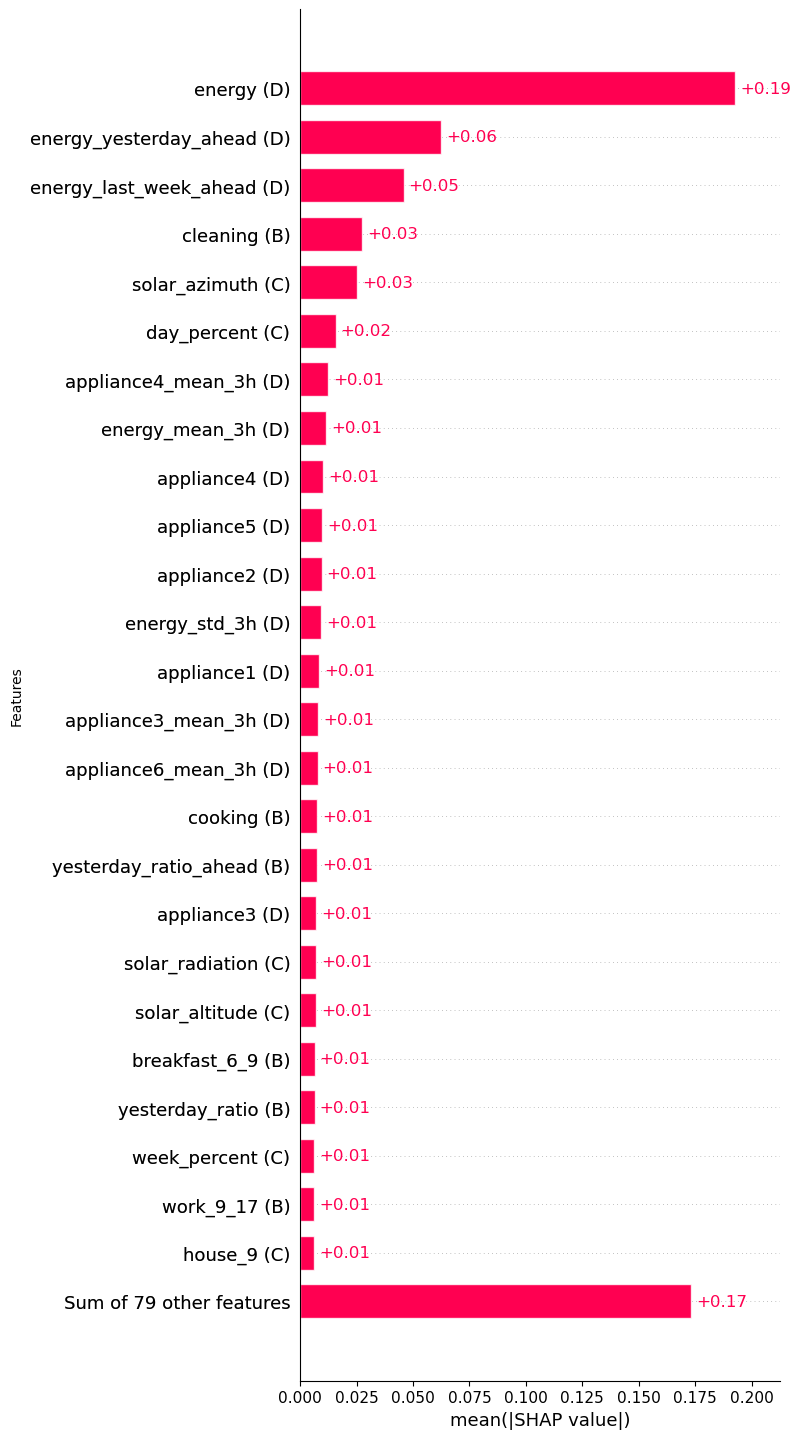

In [61]:
n_features = {'D': 0, 'C': 0, 'B': 0}
shap_contributions = {'D': 0, 'C': 0, 'B': 0}

for feature, value in zip(X_train.columns, np.mean(np.abs(shap_values.values), axis=0)):
    if feature.endswith('(D)'):
        shap_contributions['D'] += value
        n_features['D'] += 1
        continue

    elif feature.endswith('(C)'):
        shap_contributions['C'] += value
        n_features['C'] += 1
        continue

    elif feature.endswith('(B)'):
        shap_contributions['B'] += value
        n_features['B'] += 1
        continue

# Normalize
norm_shap_contributions = { key: (shap_contributions[key] / n_features[key]) for key in ['D', 'C', 'B'] }

print(f'{n_features=}; all={sum(n_features.values())};\n{shap_contributions=};\n{norm_shap_contributions=}')


# visualize all the training set predictions
shap.plots.bar(
    shap_values,
    max_display=25+1,
    show=False,
)

plt.grid(False)
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import r_regression, chi2

prediction_cols = ['prediction_1h_ahead', 'prediction_3h_ahead']

_df = df[[*(domain_features+contextual_features+behavioral_features), *prediction_cols]].copy().dropna()
_df = mapper.fit_transform(_df)
_df.rename(columns=rename, inplace=True)


corr_avg = {'D': 0, 'B': 0, 'C': 0}
count = {'D': 0, 'B': 0, 'C': 0}

for col in _df.columns:
    score = np.abs(r_regression(_df[[col]], _df[['prediction_1h_ahead']]))
    if np.isinf(score):
        print(f"Skip {col}")
        continue


    if col.endswith('(D)'):
        corr_avg['D'] += score
        count['D'] += 1

    elif col.endswith('(C)'):
        corr_avg['C'] += score
        count['C'] += 1

    elif col.endswith('(B)'):
        corr_avg['B'] += score
        count['B'] += 1

print('normalized correlation:', { k: (corr_avg[k] / count[k]) for k in count.keys() })


#data_cols = list(filter(lambda x: x.startswith('prediction') or x.endswith('(C)'), _df.columns))
#_df = _df[data_cols]

f = plt.figure(figsize=(19, 19))
plt.matshow(_df.corr(method='pearson'), fignum=f.number, interpolation='none', cmap='bwr')
plt.xticks(range(_df.shape[1]), _df.columns, fontsize=10, rotation=90)
plt.yticks(range(_df.shape[1]), _df.columns, fontsize=10)
plt.grid(False)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
X_train.head(5).T

In [ ]:
view = df[(df.house == 2) & (df.timestamp >= '2013-09-18') & (df.timestamp < '2013-10-19') & (df.timestamp.dt.weekday < 5)]

f, ax = plt.subplots()
for ts, group in view.groupby(by=view.timestamp.dt.date):
    ax.plot(group.timestamp.dt.hour, group['cooking'])

ax.set_xticks([i for i in range(24)])
ax.set_xlabel('hour')
ax.set_ylabel('Wh')

plt.show()

In [72]:
data = '0.3568 & 0.1488 & 0.0361'
data = data.split('&')
data = [x.strip() for x in data]
data = [float(x) for x in data]

ratios = [x / sum(data) for x in data]


print(' '.join([f'& {x*100:.3f}' for x in ratios]))

& 65.867 & 27.469 & 6.664
